# Applying Classification Modeling
The goal of this week's assessment is to find the model which best predicts whether a person will default on their loan. In doing so, we want to utilize all of the different tools we have learned over the course: data cleaning, EDA, feature engineering/transformation, feature selection, hyperparameter tuning, and model evaluation. 

Dataset: The dataset comes customers default payments in Taiwan. More information about the dataset and columns are found in the link below.

https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#


You will fit three different models (KNN, Logistic Regression, and Decision Tree Classifier) and use gridsearch to find the best hyperparameters for those models. Then you will compare the performance of those three models on a test set to find the best one.  


## Process/Expectations

#### You will be working in pairs for this assessment; please have ONE notebook and be prepared to explain how you worked in your pair.
1. Clean up your data set so that you can do EDA. This includes handling null values, categorical variables, removing unimportant columns, and removing outliers.
2. Perform EDA to identify opportunities to create new features.
    - [Great Example of EDA for classification](https://www.kaggle.com/stephaniestallworth/titanic-eda-classification-end-to-end) 
    - [Using Pairplots with Classification](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166)
3. Create polynomial and/or interaction features. You must also create at least 2 new features that are not interactions or polynomial transformations. For example, you can create a new dummy variable that based on the value of a continuous variable (billamount6 >2000) or take the average of some past amounts.
4. Perform some feature selction. This can happen beforehand using F-scores, or you can do it as part of your model building process by looking at the weights of your regularized logistic regression or feature importance of your decision tree.  
5. You must fit each of the three models to your data and tune at least 1 hyperparameter per model. 
6. After identifying the best hyperparameters for each model, fit those models to the test set and identify the best model overall using the evaluation metric of your choice.
7. Present your best model.

In [11]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import seaborn as sns
import warnings
warnings.filterwarnings('once')


## 1. Data Cleaning

In [14]:
#read in the data
df = pd.read_csv('student_data.csv')
df.rename(columns={"default payment next month": "default"},inplace = True)

In [15]:
#checking the output, 78/22 split so I dont think we have to worry about a class imbalance
df['default'].value_counts()

0    18691
1     5308
Name: default, dtype: int64

In [16]:
df.shape

(23999, 25)

In [17]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,2873,350000,1,1,2,37,-2,-2,-2,-2,...,466,466,316,316,316,466,466,316,316,0
1,3598,50000,2,2,1,37,2,2,2,0,...,13026,13268,13497,5500,0,580,600,600,600,0
2,27623,50000,2,1,2,23,-1,-1,-1,-1,...,4800,9810,660,2548,2321,4800,9810,660,2980,0
3,6874,20000,1,3,1,56,0,0,0,0,...,13784,13420,13686,1508,1216,1116,0,490,658,0
4,6444,110000,2,2,2,32,0,0,0,0,...,108829,110557,106082,5400,5400,4100,4100,4100,4200,0


In [7]:
#No null values! Will look at the stats next
df.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

In [8]:
#Dropping ID since we don't need to index them additionally
df = df.drop(columns = ['ID'],axis=1)

Target Variable
default
0    18691
1     5308
Name: default, dtype: int64


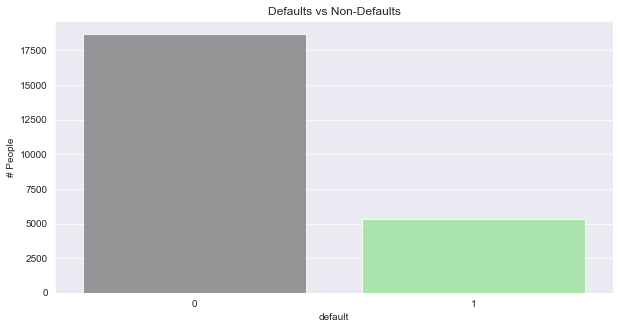

In [19]:
# Default Count
print('Target Variable')
print(df.groupby(['default']).default.count())

# Target Variable Countplot
sns.set_style('darkgrid')
plt.figure(figsize = (10,5))
sns.countplot(df['default'], alpha =.80, palette= ['grey','lightgreen'])
plt.title('Defaults vs Non-Defaults')
plt.ylabel('# People')
plt.show()

Continuous Variables
             count           mean            std       min      25%       50%  \
LIMIT_BAL  23999.0  167825.729405  129915.115993   10000.0  50000.0  140000.0   
AGE        23999.0      35.523230       9.253986      21.0     28.0      34.0   
BILL_AMT1  23999.0   51589.034710   74104.132627 -165580.0   3577.5   22472.0   
BILL_AMT2  23999.0   49521.698112   71551.215125  -67526.0   2958.0   21290.0   
BILL_AMT3  23999.0   47474.826368   70010.815328 -157264.0   2718.0   20223.0   
BILL_AMT4  23999.0   43796.589775   64927.450125 -170000.0   2392.5   19145.0   
BILL_AMT5  23999.0   40748.049169   61257.537699  -81334.0   1801.0   18227.0   
BILL_AMT6  23999.0   39226.852411   60075.536736 -339603.0   1280.0   17175.0   
PAY_AMT1   23999.0    5687.720113   16698.506577       0.0   1000.0    2110.0   
PAY_AMT2   23999.0    6019.571357   24541.362830       0.0    858.5    2012.0   
PAY_AMT3   23999.0    5253.322805   17967.028860       0.0    395.0    1809.0   
PAY_AMT

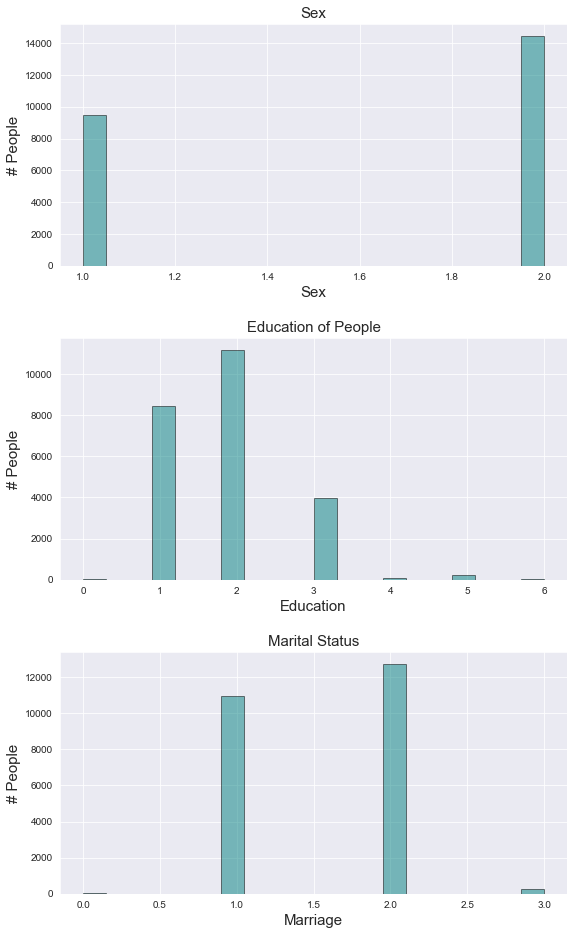

In [20]:
# Identify numeric features
print('Continuous Variables')
print(df[['LIMIT_BAL','AGE','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1'
         ,'PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']].describe().transpose())
print('--'*40)
print('Discrete Variables')
print(df.groupby('SEX').SEX.count())
print(df.groupby('EDUCATION').EDUCATION.count())
print(df.groupby('MARRIAGE').MARRIAGE.count())

   
# Subplots of Numeric Features
sns.set_style('darkgrid')
fig = plt.figure(figsize = (20,16))
fig.subplots_adjust(hspace = .30)

ax1 = fig.add_subplot(321)
ax1.hist(df['SEX'], bins = 20, alpha = .50,edgecolor= 'black',color ='teal')
ax1.set_xlabel('Sex', fontsize = 15)
ax1.set_ylabel('# People',fontsize = 15)
ax1.set_title('Sex',fontsize = 15)

ax2 = fig.add_subplot(323)
ax2.hist(df['EDUCATION'], bins = 20, alpha = .50,edgecolor= 'black',color ='teal')
ax2.set_xlabel('Education',fontsize = 15)
ax2.set_ylabel('# People',fontsize = 15)
ax2.set_title('Education of People',fontsize = 15)

ax3 = fig.add_subplot(325)
ax3.hist(df['MARRIAGE'], bins = 20, alpha = .50,edgecolor= 'black',color ='teal')
ax3.set_xlabel('Marriage',fontsize = 15)
ax3.set_ylabel('# People',fontsize = 15)
ax3.set_title('Marital Status',fontsize = 15)



plt.show()

In [14]:
df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,23999.000000,23999.000000,23999.000000,23999.000000,23999.000000,23999.000000,23999.000000,23999.000000,23999.000000,23999.000000,...,23999.000000,23999.000000,23999.000000,23999.000000,2.399900e+04,23999.000000,23999.000000,23999.000000,23999.000000,23999.000000
mean,167825.729405,1.603608,1.856786,1.550773,35.523230,-0.014959,-0.134839,-0.165632,-0.217092,-0.261344,...,43796.589775,40748.049169,39226.852411,5687.720113,6.019571e+03,5253.322805,4824.490687,4825.033793,5245.642943,0.221176
std,129915.115993,0.489158,0.791939,0.522431,9.253986,1.120903,1.193044,1.193515,1.168719,1.133016,...,64927.450125,61257.537699,60075.536736,16698.506577,2.454136e+04,17967.028860,15730.753527,15596.580167,17795.775322,0.415047
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2392.500000,1801.000000,1280.000000,1000.000000,8.585000e+02,395.000000,300.000000,269.500000,125.000000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19145.000000,18227.000000,17175.000000,2110.000000,2.012000e+03,1809.000000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,55418.000000,50581.000000,49434.500000,5020.000000,5.000000e+03,4561.000000,4089.000000,4029.500000,4008.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000,1.000000


In [39]:
#SEX: Gender (1=male, 2=female)
df['SEX'].value_counts()

0    14486
1     9513
Name: SEX, dtype: int64

In [38]:
#SEX: 0 = female, 1 = male
df['SEX']=df['SEX'].apply(lambda x: 0 if x ==2 else x)
df['SEX'].value_counts()

0    14486
1     9513
Name: SEX, dtype: int64

In [26]:
df['EDUCATION'].describe()

count    23999.000000
mean         1.856786
std          0.791939
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          6.000000
Name: EDUCATION, dtype: float64

In [31]:
df['EDUCATION'].value_counts()

2    11188
1     8442
3     3994
5      223
4      100
6       41
0       11
Name: EDUCATION, dtype: int64

In [36]:
#Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
#setting 0,4-6 to others
df['EDUCATION']=df['EDUCATION'].apply(lambda x: 0 if x >=4 else x)

df['EDUCATION'].value_counts()
#dummy_edu = pd.get_dummies(df['EDUCATION'], drop_first=True)

#dummy_edu.describe()

2    11188
1     8442
3     3994
0      375
Name: EDUCATION, dtype: int64

In [30]:
df['MARRIAGE'].value_counts()

2    12735
1    10958
3      263
0       43
Name: MARRIAGE, dtype: int64

In [37]:
#MARRIAGE: Marital status (1=married, 2=single, 3=others)

df['MARRIAGE']=df['MARRIAGE'].apply(lambda x: 0 if x ==3 else x)
dummy_mar = pd.get_dummies(df['MARRIAGE'], drop_first=True)

dummy_mar.describe()

,1,2
count,23999.000000,23999.000000
mean,0.456602,0.530647
std,0.498123,0.499070
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


## 2. EDA

## 3. Feature Engineering

## 4. Feature Selection

## 5. Model Fitting and Hyperparameter Tuning
KNN, Logistic Regression, Decision Tree

## 6. Model Evaluation

## 7. Final Model